In [1]:
# Import packages
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,make_scorer
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

# For saving models
import pickle

# For Warnings Ignore
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

import os

## Load Data


In [2]:
# /kaggle/input/titanic/train.csv
# /kaggle/input/titanic/test.csv
# /kaggle/input/titanic/gender_submission.csv

df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')

# Data Exploration (Initial EDA and data cleaning)

- Understand your variables
- Clean your dataset (missing data, redundant data, outliers) 

* PassengerId is the unique id of the row and it doesn't have any effect on target
* Survived is the target variable we are trying to predict (0 or 1):
    * 1 = Survived
    * 0 = Not Survived
* Pclass (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature * which has 3 unique values (1, 2 or 3):
    * 1 = Upper Class
    * 2 = Middle Class
    * 3 = Lower Class
* Name, Sex and Age are self-explanatory
* SibSp is the total number of the passengers' siblings and spouse
* Parch is the total number of the passengers' parents and children
* Ticket is the ticket number of the passenger
* Fare is the passenger fare
* Cabin is the cabin number of the passenger
* Embarked is port of embarkation and it is a categorical feature which has 3 unique values (C, Q or S):
    * C = Cherbourg
    * Q = Queenstown
    * S = Southampton

In [3]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [4]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,418.0,1100.500000,120.810458,892.00,996.2500,1100.5000,1204.75,1309.0000
Pclass,418.0,2.265550,0.841838,1.00,1.0000,3.0000,3.00,3.0000
Age,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.00,76.0000
SibSp,418.0,0.447368,0.896760,0.00,0.0000,0.0000,1.00,8.0000
Parch,418.0,0.392344,0.981429,0.00,0.0000,0.0000,0.00,9.0000
Fare,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.50,512.3292


In [5]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [6]:
#get the shape of data 
print(f'train : {df_train.shape} \ntest : {df_test.shape}')

train : (891, 12) 
test : (418, 11)


In [7]:
# check for duplicates
print(f'train : {df_train.duplicated().sum()} \ntest : {df_test.duplicated().sum()}')

train : 0 
test : 0


#### Which features are available in the dataset?

#### Which features are categorical?

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

* Nominal: Survived(Binary), Sex and Embarked.
* Ordinal: Pclass.

#### Which features are numerical?

Which features are numerical? These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

* Continous: Age, Fare.
* Discrete: SibSp, Parch.

#### Which features are mixed data types?

Numerical, alphanumeric data within same feature. These are candidates for correcting goal.

* Ticket is a mix of numeric and alphanumeric data types. Cabin is alphanumeric.

##### We are going to merge the test and train data to fix the missing values then split them again afterwards

In [8]:
df_all = pd.concat([df_train, df_test]).reset_index(drop=True)
df_all.head(-10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1294,1295,NaN,1,"Carrau, Mr. Jose Pedro",male,17.0,0,0,113059,47.1000,NaN,S
1295,1296,NaN,1,"Frauenthal, Mr. Isaac Gerald",male,43.0,1,0,17765,27.7208,D40,C
1296,1297,NaN,2,"Nourney, Mr. Alfred (Baron von Drachstedt"")""",male,20.0,0,0,SC/PARIS 2166,13.8625,D38,C
1297,1298,NaN,2,"Ware, Mr. William Jeffery",male,23.0,1,0,28666,10.5000,NaN,S


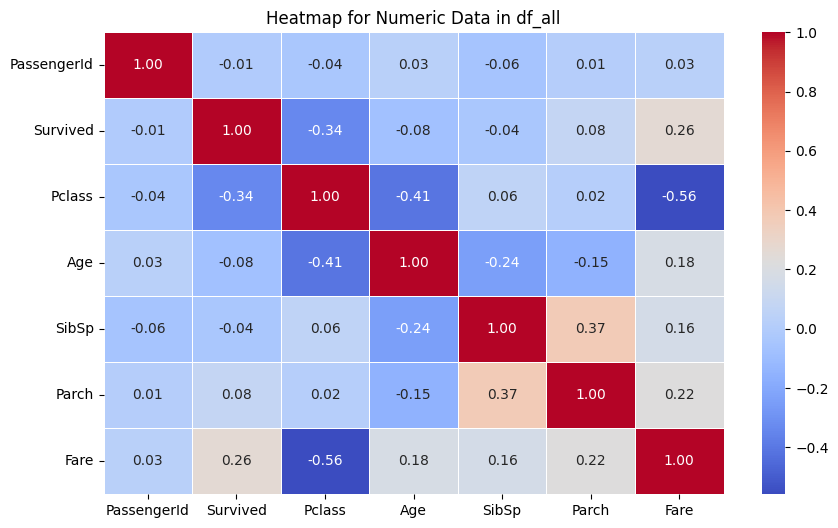

In [9]:
# Select only numeric columns for the heatmap
numeric_columns = df_all.select_dtypes(include='number')

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
heatmap_data = numeric_columns.corr()  # Calculate correlation matrix
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap for Numeric Data in df_all')
plt.show()

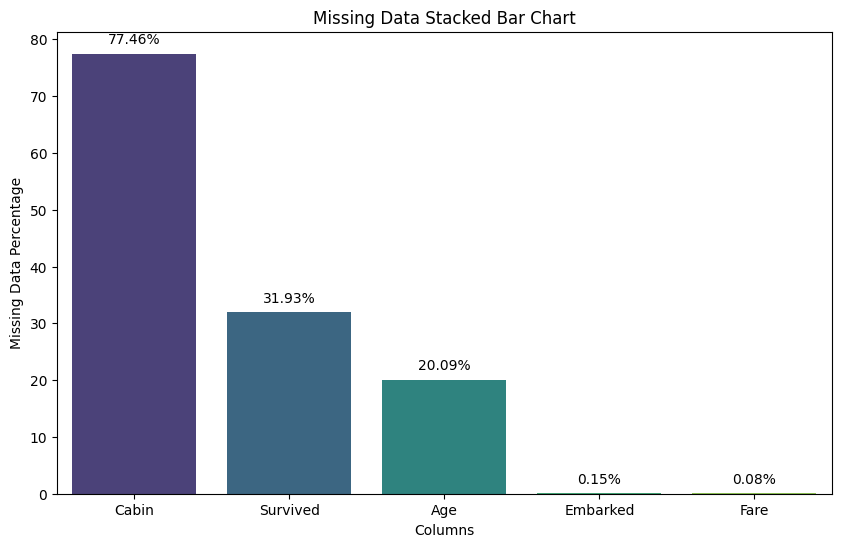

In [10]:
# Calculate missing data percentage for each column
missing_count = df_all.isnull().sum()
missing_percentage = (missing_count / len(df_all)) * 100
missing_data = pd.DataFrame({'Column': missing_percentage.index, 'MissingPercentage': missing_percentage.values, 'MissingCount': missing_count.values})

# Filter out columns with zero missing values
missing_data = missing_data[missing_data['MissingPercentage'] > 0]

# Round the missing percentage to 3 decimal places
missing_data['MissingPercentage'] = missing_data['MissingPercentage'].round(3)
missing_data = missing_data.sort_values(by='MissingPercentage', ascending=False)
# Plot the missing data as a stacked bar chart using seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Column', y='MissingPercentage', data=missing_data, palette='viridis')

# Add the rounded missing value percentages inside the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Missing Data Stacked Bar Chart')
plt.xlabel('Columns')
plt.ylabel('Missing Data Percentage')
plt.show()

## Cabin

cabin has 77% missing values its a huge number , we could remove this feature from our selection as we build the model, or we can try to look for clues in the other features to replace the missing values.

In [11]:
# Assign all the null values to N
df_all.Cabin.fillna("N", inplace=True)

# group these cabins according to the letter of the cabin name 
df_all.Cabin = [str(i)[0] for i in df_all.Cabin]

In [12]:
df_all.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,N,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,N,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,N,S
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,N,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,N,S
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,N,S
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,N,C


In [13]:
# Group by 'Cabin' and calculate the mean fare for each group
fare_mean_by_cabin = df_all.groupby('Cabin')['Fare'].mean().reset_index()
fare_mean_by_cabin = fare_mean_by_cabin.sort_values(by='Fare', ascending=False).reset_index(drop=True).round()


# Print the result
print(fare_mean_by_cabin)

  Cabin   Fare
0     B  122.0
1     C  108.0
2     E   55.0
3     D   53.0
4     A   41.0
5     T   36.0
6     N   19.0
7     F   18.0
8     G   14.0


In [14]:
from pprint import pprint
# remove N
fare_mean_by_cabin = fare_mean_by_cabin[fare_mean_by_cabin['Cabin'] != 'N']

# create a dict
replacement_values = fare_mean_by_cabin[['Cabin', 'Fare']].to_dict(orient='records')

# Sort the list of dictionaries based on 'Fare' values in descending order
replacement_values = sorted(replacement_values, key=lambda x: x['Fare'], reverse=True)

pprint(replacement_values)

[{'Cabin': 'B', 'Fare': 122.0},
 {'Cabin': 'C', 'Fare': 108.0},
 {'Cabin': 'E', 'Fare': 55.0},
 {'Cabin': 'D', 'Fare': 53.0},
 {'Cabin': 'A', 'Fare': 41.0},
 {'Cabin': 'T', 'Fare': 36.0},
 {'Cabin': 'F', 'Fare': 18.0},
 {'Cabin': 'G', 'Fare': 14.0}]


In [15]:
# Estimate Cabin based on Fare 
def cabin_estimator(i):
    fare_ranges = [(0, 16, 'G'), (16, 27, 'F'), (27, 38, 'T'), (38, 47, 'A'), (47, 53, 'E'), (53, 54, 'D'), (54, 116, 'C')]
    for start, end, cabin in fare_ranges:
        if start <= i < end:
            return cabin
    return "B"  # Default value if not in any range

df_all['Cabin'] = df_all.Fare.apply(lambda x: cabin_estimator(x))

# check 
(df_all['Cabin'] == 'N').sum()

0

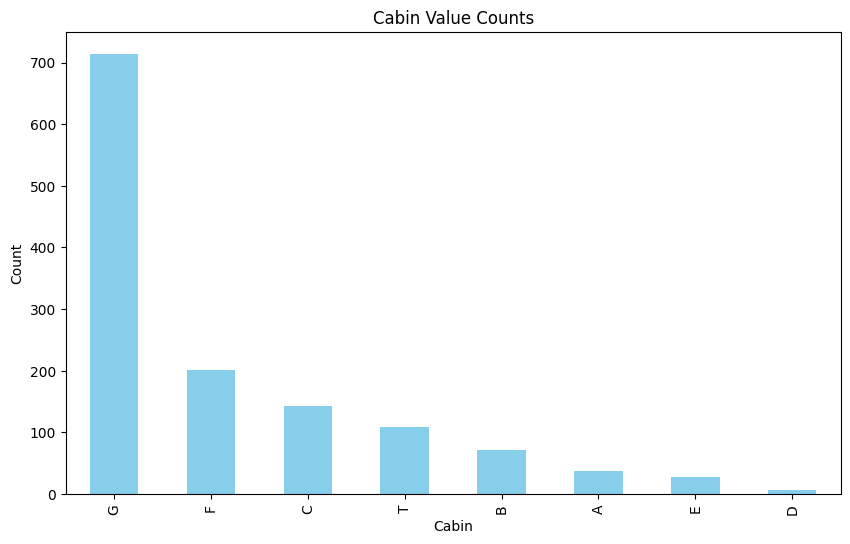

In [16]:
# Count occurrences of each 'Cabin' value
cabin_counts = df_all['Cabin'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
cabin_counts.plot(kind='bar', color='skyblue')
plt.title('Cabin Value Counts')
plt.xlabel('Cabin')
plt.ylabel('Count')
plt.show()

## Age


In [17]:
df_all['Age'].isnull().mean()

0.20091673032849502

19% of age values are missing, age might be a huge factor in surviving, in the light of how fit you are to run up the stairs and fight the cold weather in the sea. we should look for clause first before dropping the values.

In [18]:
df_all['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

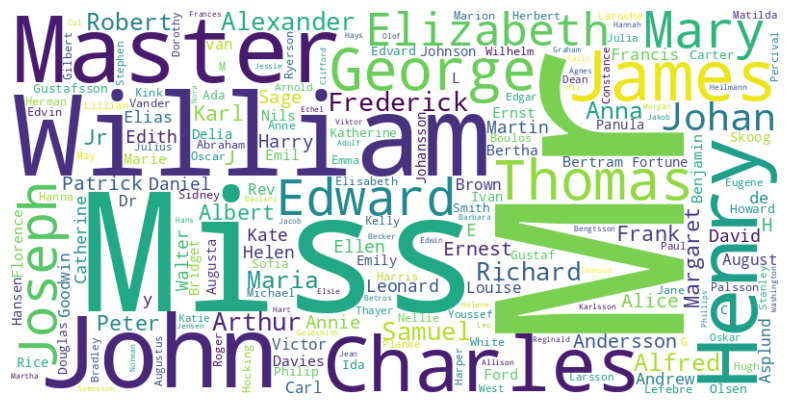

In [19]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

# Concatenate the text column values into a single string
text = ' '.join(df_all['Name'])

# Create a WordCloud object with collocations set to False
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS, collocations=False).generate(text)

# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.show()

In [20]:
# extract the intials 
# extract any words before a dot
df_all['Initial']=0
for i in df_all:
    df_all['Initial']=df_all.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

# check the extraction
pd.crosstab(df_all.Initial,df_all.Sex).T.style.background_gradient(cmap='summer_r')  # Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [21]:
df_all['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mrs'],inplace=True)
df_all.groupby('Initial')['Age'].mean()  # lets check the average age by Initials

Initial
Master     5.482642
Miss      21.834533
Mr        32.545531
Mrs       37.046243
Other     44.923077
Name: Age, dtype: float64

In [22]:
# Define mean ages by initial
mean_ages = {'Mr': 33, 'Mrs': 37, 'Master': 5, 'Miss': 22, 'Other': 45}

# Assigning NaN values with the mean ages
for initial, mean_age in mean_ages.items():
    df_all.loc[(df_all.Age.isnull()) & (df_all.Initial == initial), 'Age'] = mean_age

# Check if any null values are left
print(df_all.Age.isnull().any())

False


## Embarked
Embarked feature takes S, Q, C values based on port of embarkation. It looks like there are only two null values( ~ 0.22 %) in the Embarked feature, we can replace these with the mode value "S". However, let's dig a little deeper. Let's see what are those two null values

In [23]:
df_all['Embarked'].value_counts()

Embarked
S    914
C    270
Q    123
Name: count, dtype: int64

In [24]:
df_all[df_all['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,C,NaN,Miss
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,C,NaN,Mrs


In [25]:
df_all.groupby('Embarked')['Fare'].mean()

Embarked
C    62.336267
Q    12.409012
S    27.418824
Name: Fare, dtype: float64

In [26]:
# replacing the null values with C as null values fares equal 80.
df_all['Embarked'].fillna('C', inplace = True)

# check
df_all['Embarked'].isnull().sum()

0

## Fare

In [27]:
df_all[df_all['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,B,S,Mr


In [28]:
# Embarked from S port the Fare mean is 27.5
df_all['Fare'].fillna(27.5, inplace = True)

# check
df_all['Fare'].isnull().sum()

0

# Feature Engineering
##### Using practical, statistical, and data science knowledge to select, transform, or extract characteristics from raw data.
 ### **1. Feature Selection:**

- **Purpose:**
    - Choosing variables to use as predictor variables for the model.
- **Considerations:**
    - Eliminate redundant and irrelevant features.
    - Enhances model performance by focusing on informative features.

### **2. Feature Transformation:**

- **Purpose:**
    - Modify existing features to improve model training accuracy.
- **Log Normalization:**
    - Transforming skewed continuous variables using the natural logarithm.
    - Converts log-normal distributions to normal distributions.
- **Scaling:**
    - **Normalization (MinMaxScaler):**
        - Transforms data to a range between 0 and 1.
        - Prevents features with large values from dominating the model.
    - **Standardization (StandardScaler):**
        - Gives features a mean of 0 and a standard deviation of 1.
        - Useful for machine learning algorithms sensitive to feature magnitudes.
- **Encoding:**
    - **One-Hot Encoding:**
        - Converts categorical data into binary vectors.
        - Creates binary columns for each category.
    - **Ordinal Encoding:**
        - Used for categorical data with inherent order or ranking.
        - Assigns numerical values while preserving the order.

### **3. Feature Extraction:**

- **Definition:**
    - Producing new features from existing ones to enhance predictive power.
- **Example:**
    - Creating "Days Since Last Purchase" from "Date of Last Purchase."
    - Offers valuable insights for model predictions.


### **Types of Features:**

   - **Predictive Features:**
        - Independently informative for predicting the target.
   - **Interactive Features:**
        - Gain predictiveness when combined with other features.
   - **Irrelevant Features:**
        - Lack useful information for prediction.
   - **Redundant Features:**
        - Highly correlated, providing no new information.


In [29]:
# Transform catgorial data Sex, Cabin and Embarked into numruical form.
df_all = pd.get_dummies(df_all, columns=['Sex', 'Cabin', 'Embarked'], drop_first=True)

df_all.head(10)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Initial,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_Q,Embarked_S
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,Mr,True,False,False,False,False,False,True,False,False,True
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,Mrs,False,False,True,False,False,False,False,False,False,False
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,Miss,False,False,False,False,False,False,True,False,False,True
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,Mrs,False,False,False,True,False,False,False,False,False,True
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,Mr,True,False,False,False,False,False,True,False,False,True
5,6,0.0,3,"Moran, Mr. James",33.0,0,0,330877,8.4583,Mr,True,False,False,False,False,False,True,False,True,False
6,7,0.0,1,"McCarthy, Mr. Timothy J",54.0,0,0,17463,51.8625,Mr,True,False,False,False,True,False,False,False,False,True
7,8,0.0,3,"Palsson, Master. Gosta Leonard",2.0,3,1,349909,21.0750,Master,True,False,False,False,False,True,False,False,False,True
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,0,2,347742,11.1333,Mrs,False,False,False,False,False,False,True,False,False,True
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,1,0,237736,30.0708,Mrs,False,False,False,False,False,False,False,True,False,False


In [30]:
# Extract a more valuable feature from sibsp and parch as family size.
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1  # Adding 1 for the person himself

# Drop 'SibSp' and 'Parch'
df_all = df_all.drop(['SibSp', 'Parch'], axis=1)

df_all.head(10)

,PassengerId,Survived,Pclass,Name,Age,Ticket,Fare,Initial,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_Q,Embarked_S,Family_Size
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,A/5 21171,7.2500,Mr,True,False,False,False,False,False,True,False,False,True,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,PC 17599,71.2833,Mrs,False,False,True,False,False,False,False,False,False,False,2
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,STON/O2. 3101282,7.9250,Miss,False,False,False,False,False,False,True,False,False,True,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,113803,53.1000,Mrs,False,False,False,True,False,False,False,False,False,True,2
4,5,0.0,3,"Allen, Mr. William Henry",35.0,373450,8.0500,Mr,True,False,False,False,False,False,True,False,False,True,1
5,6,0.0,3,"Moran, Mr. James",33.0,330877,8.4583,Mr,True,False,False,False,False,False,True,False,True,False,1
6,7,0.0,1,"McCarthy, Mr. Timothy J",54.0,17463,51.8625,Mr,True,False,False,False,True,False,False,False,False,True,1
7,8,0.0,3,"Palsson, Master. Gosta Leonard",2.0,349909,21.0750,Master,True,False,False,False,False,True,False,False,False,True,5
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,347742,11.1333,Mrs,False,False,False,False,False,False,True,False,False,True,3
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,237736,30.0708,Mrs,False,False,False,False,False,False,False,True,False,False,2


In [31]:
df_all['Family_Size'].isnull().mean()

0.0

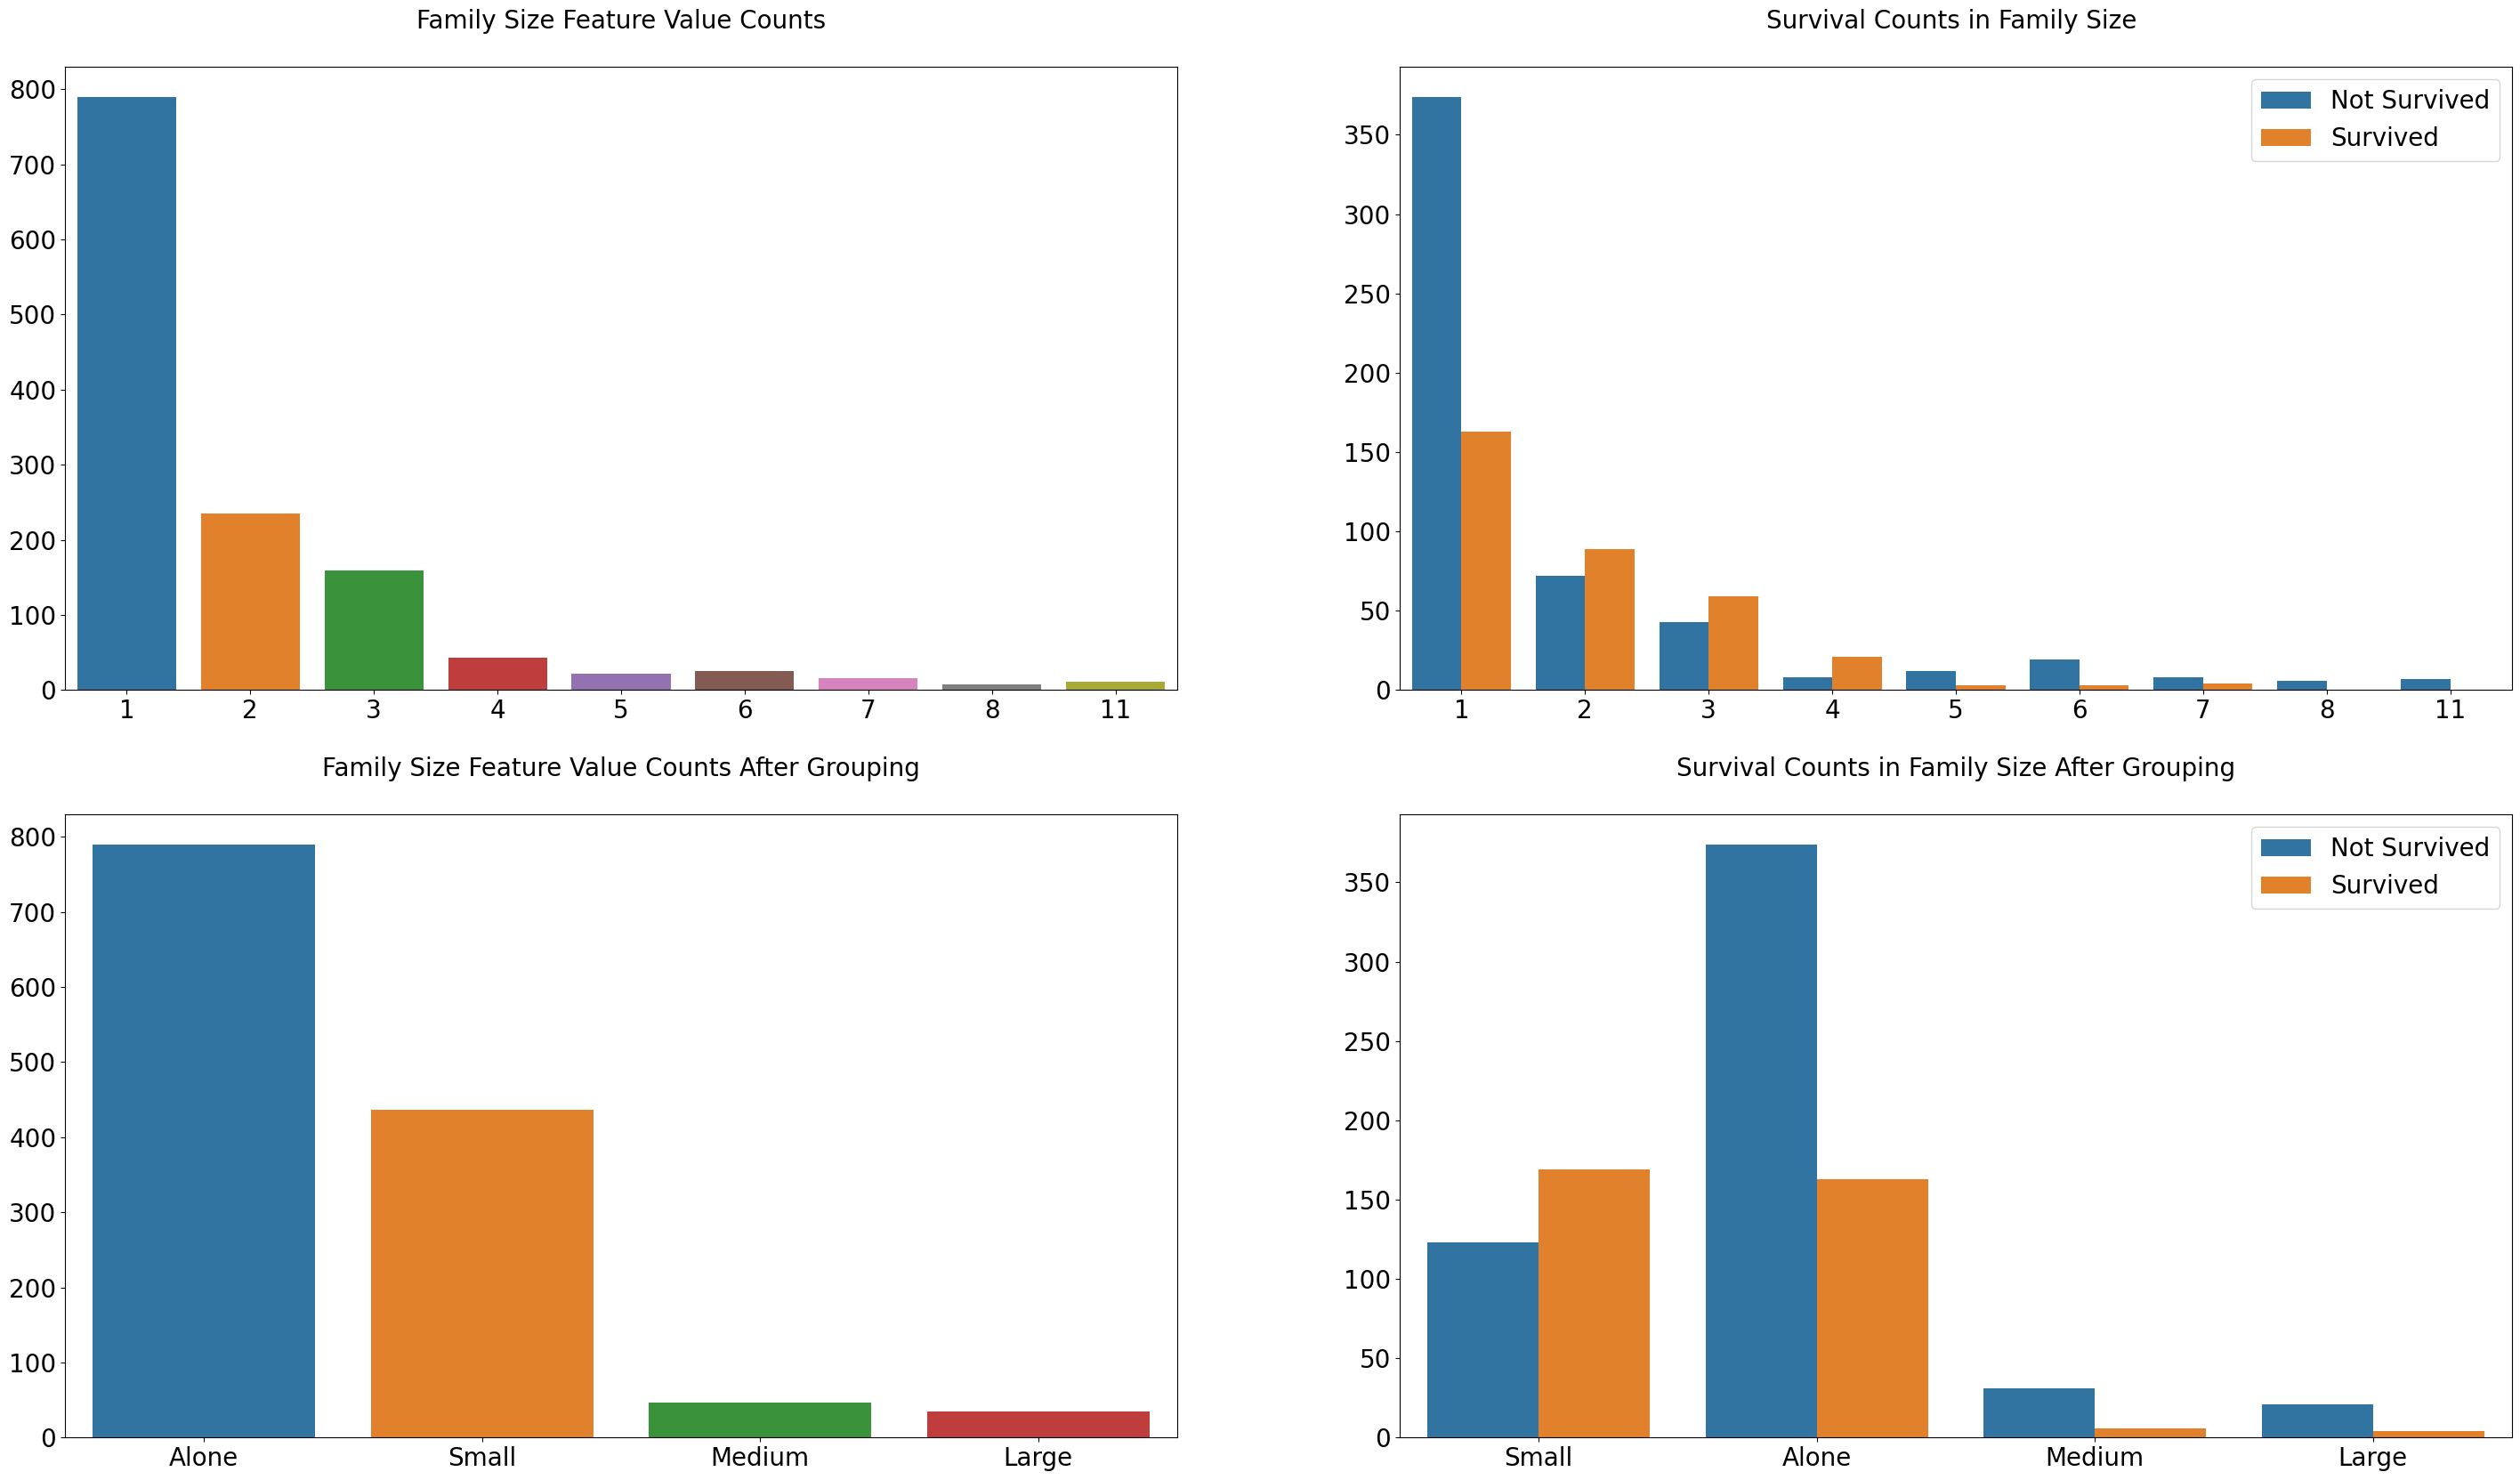

In [32]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

In [33]:
df_all.head(-10)

,PassengerId,Survived,Pclass,Name,Age,Ticket,Fare,Initial,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_Q,Embarked_S,Family_Size,Family_Size_Grouped
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,A/5 21171,7.2500,Mr,True,False,False,False,False,False,True,False,False,True,2,Small
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,PC 17599,71.2833,Mrs,False,False,True,False,False,False,False,False,False,False,2,Small
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,STON/O2. 3101282,7.9250,Miss,False,False,False,False,False,False,True,False,False,True,1,Alone
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,113803,53.1000,Mrs,False,False,False,True,False,False,False,False,False,True,2,Small
4,5,0.0,3,"Allen, Mr. William Henry",35.0,373450,8.0500,Mr,True,False,False,False,False,False,True,False,False,True,1,Alone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,1295,NaN,1,"Carrau, Mr. Jose Pedro",17.0,113059,47.1000,Mr,True,False,False,False,True,False,False,False,False,True,1,Alone
1295,1296,NaN,1,"Frauenthal, Mr. Isaac Gerald",43.0,17765,27.7208,Mr,True,False,False,False,False,False,False,True,False,False,2,Small
1296,1297,NaN,2,"Nourney, Mr. Alfred (Baron von Drachstedt"")""",20.0,SC/PARIS 2166,13.8625,Mr,True,False,False,False,False,False,True,False,False,False,1,Alone
1297,1298,NaN,2,"Ware, Mr. William Jeffery",23.0,28666,10.5000,Mr,True,False,False,False,False,False,True,False,False,True,2,Small


In [34]:
df_all['Fare_Rate'] = pd.cut(df_all['Fare'][:891], bins=range(0, 526, 25), labels=[f'{i}-{i+24}' for i in range(0, 525, 25)])

# Calculate the survival rate for each fare group
fare_group_stats = df_all.groupby('Fare_Rate')['Survived'].agg(['mean', 'count']).reset_index()
fare_group_stats.columns = ['Fare_Rate', 'Survival Rate', 'Count']

# Print the results
print(fare_group_stats)

   Fare_Rate  Survival Rate  Count
0       0-24       0.293358    542
1      25-49       0.419540    174
2      50-74       0.555556     63
3      75-99       0.795455     44
4    100-124       0.733333     15
5    125-149       0.888889      9
6    150-174       0.666667      9
7    175-199            NaN      0
8    200-224       0.600000      5
9    225-249       0.666667      6
10   250-274       0.666667      6
11   275-299            NaN      0
12   300-324            NaN      0
13   325-349            NaN      0
14   350-374            NaN      0
15   375-399            NaN      0
16   400-424            NaN      0
17   425-449            NaN      0
18   450-474            NaN      0
19   475-499            NaN      0
20   500-524       1.000000      3


  FareGroup  Survived
0       low  0.293358
1    medium  0.455696
2      high  0.762887


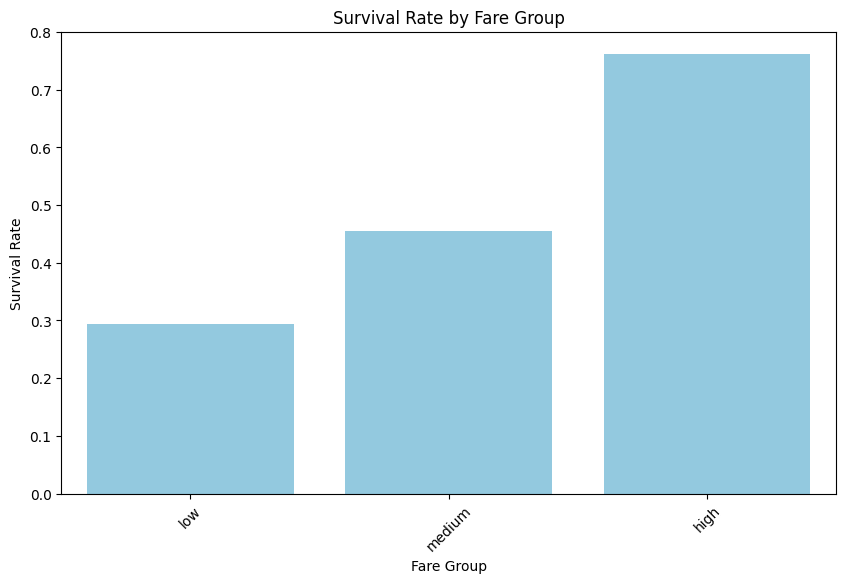

In [35]:
df_all['FareGroup'] = pd.cut(df_all['Fare'], bins=[0, 25, 74, float('inf')],
                             labels=['low', 'medium', 'high'])

# Calculate the survival rate for each fare group
fare_group_stats = df_all.groupby('FareGroup')['Survived'].mean().reset_index()

# Print the results
print(fare_group_stats)

# Plot the survival rate for each fare group with the new labels
plt.figure(figsize=(10, 6))
sns.barplot(x='FareGroup', y='Survived', data=fare_group_stats, color='skyblue')
plt.title('Survival Rate by Fare Group')
plt.xlabel('Fare Group')
plt.ylabel('Survival Rate')
plt.xticks(rotation=45)
plt.show()

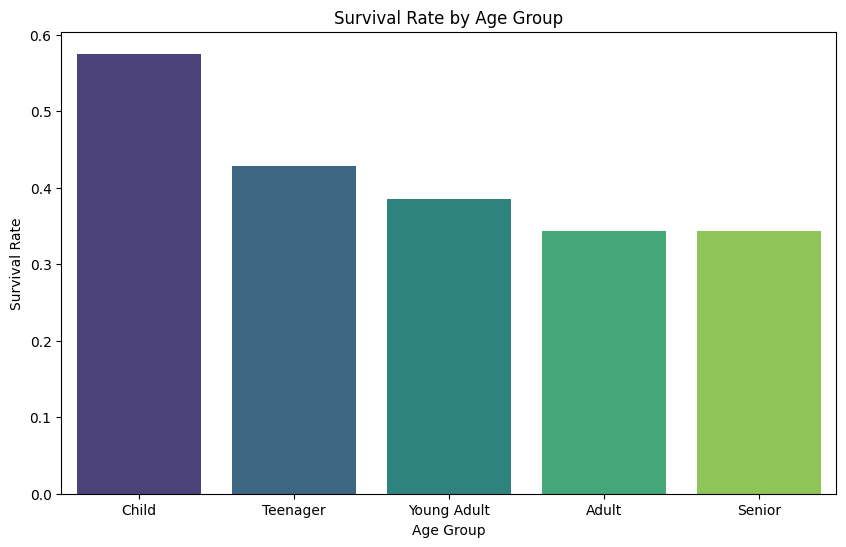

In [36]:
df_all['AgeGroup'] = pd.cut(df_all['Age'], bins=[0, 12, 18, 30, 50, 100], labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior'])

# Calculate the survival rate for each age group
age_group_stats = df_all.groupby('AgeGroup')['Survived'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='AgeGroup', y='Survived', data=age_group_stats, palette='viridis')
plt.title('Survival Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate')
plt.show()

In [37]:
df_all = pd.get_dummies(df_all, columns=['FareGroup', 'AgeGroup', 'Family_Size_Grouped'], drop_first=True)

In [38]:
df_all.head(-10)

,PassengerId,Survived,Pclass,Name,Age,Ticket,Fare,Initial,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_Q,Embarked_S,Family_Size,Fare_Rate,FareGroup_medium,FareGroup_high,AgeGroup_Teenager,AgeGroup_Young Adult,AgeGroup_Adult,AgeGroup_Senior,Family_Size_Grouped_Large,Family_Size_Grouped_Medium,Family_Size_Grouped_Small
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,A/5 21171,7.2500,Mr,True,False,False,False,False,False,True,False,False,True,2,0-24,False,False,False,True,False,False,False,False,True
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,PC 17599,71.2833,Mrs,False,False,True,False,False,False,False,False,False,False,2,50-74,True,False,False,False,True,False,False,False,True
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,STON/O2. 3101282,7.9250,Miss,False,False,False,False,False,False,True,False,False,True,1,0-24,False,False,False,True,False,False,False,False,False
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,113803,53.1000,Mrs,False,False,False,True,False,False,False,False,False,True,2,50-74,True,False,False,False,True,False,False,False,True
4,5,0.0,3,"Allen, Mr. William Henry",35.0,373450,8.0500,Mr,True,False,False,False,False,False,True,False,False,True,1,0-24,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,1295,NaN,1,"Carrau, Mr. Jose Pedro",17.0,113059,47.1000,Mr,True,False,False,False,True,False,False,False,False,True,1,NaN,True,False,True,False,False,False,False,False,False
1295,1296,NaN,1,"Frauenthal, Mr. Isaac Gerald",43.0,17765,27.7208,Mr,True,False,False,False,False,False,False,True,False,False,2,NaN,True,False,False,False,True,False,False,False,True
1296,1297,NaN,2,"Nourney, Mr. Alfred (Baron von Drachstedt"")""",20.0,SC/PARIS 2166,13.8625,Mr,True,False,False,False,False,False,True,False,False,False,1,NaN,False,False,False,True,False,False,False,False,False
1297,1298,NaN,2,"Ware, Mr. William Jeffery",23.0,28666,10.5000,Mr,True,False,False,False,False,False,True,False,False,True,2,NaN,False,False,False,True,False,False,False,False,True


# Building and Tuning Machine Learning Models

In this analysis, we aim to develop predictive models using four different machine learning algorithms: Decision Trees, Random Forest, XGBoost, and Support Vector Machines (SVM). Each of these models offers unique advantages and characteristics that can be leveraged to predict outcomes based on the Titanic dataset.

## Decision Trees
Decision Trees are versatile models that recursively split the dataset based on features, creating a tree-like structure to make predictions. They are interpretable and can capture complex relationships within the data.

## Random Forest
Random Forest is an ensemble method that combines multiple decision trees to improve predictive performance. By aggregating the results of individual trees, Random Forest tends to generalize well and provides robust predictions.

## XGBoost
XGBoost (Extreme Gradient Boosting) is a powerful gradient boosting algorithm known for its speed and efficiency. It sequentially builds trees, minimizing errors of the previous ones, and can handle missing data and regularization.

## Support Vector Machines (SVM)
SVM is a supervised learning algorithm that classifies data points by finding the optimal hyperplane that maximally separates different classes. It is particularly effective in high-dimensional spaces and is well-suited for binary classification tasks.

In the subsequent sections, we will build and train each model, followed by hyperparameter tuning to optimize their performance on the Titanic dataset.

In [39]:
# drop columns
columns_to_drop = ['Name', 'Age', 'Ticket', 'Fare', 'Initial', 'PassengerId', 'Fare_Rate','Family_Size']
df_all = df_all.drop(columns_to_drop, axis=1)
df_all.head(5)

,Survived,Pclass,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_Q,Embarked_S,FareGroup_medium,FareGroup_high,AgeGroup_Teenager,AgeGroup_Young Adult,AgeGroup_Adult,AgeGroup_Senior,Family_Size_Grouped_Large,Family_Size_Grouped_Medium,Family_Size_Grouped_Small
0,0.0,3,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True
1,1.0,1,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True
2,1.0,3,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False
3,1.0,1,False,False,False,True,False,False,False,False,False,True,True,False,False,False,True,False,False,False,True
4,0.0,3,True,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False


### Preparing Data

In [40]:
# Splitting df_all_binned back into training and test sets
df_train = df_all.iloc[:891, :].reset_index(drop=True)
df_test = df_all.iloc[891: :].reset_index(drop=True)

# Display the shapes of the resulting DataFrames
print("Training set shape:", df_train.shape)
print("Testing set shape:", df_test.shape)

Training set shape: (891, 21)
Testing set shape: (418, 21)


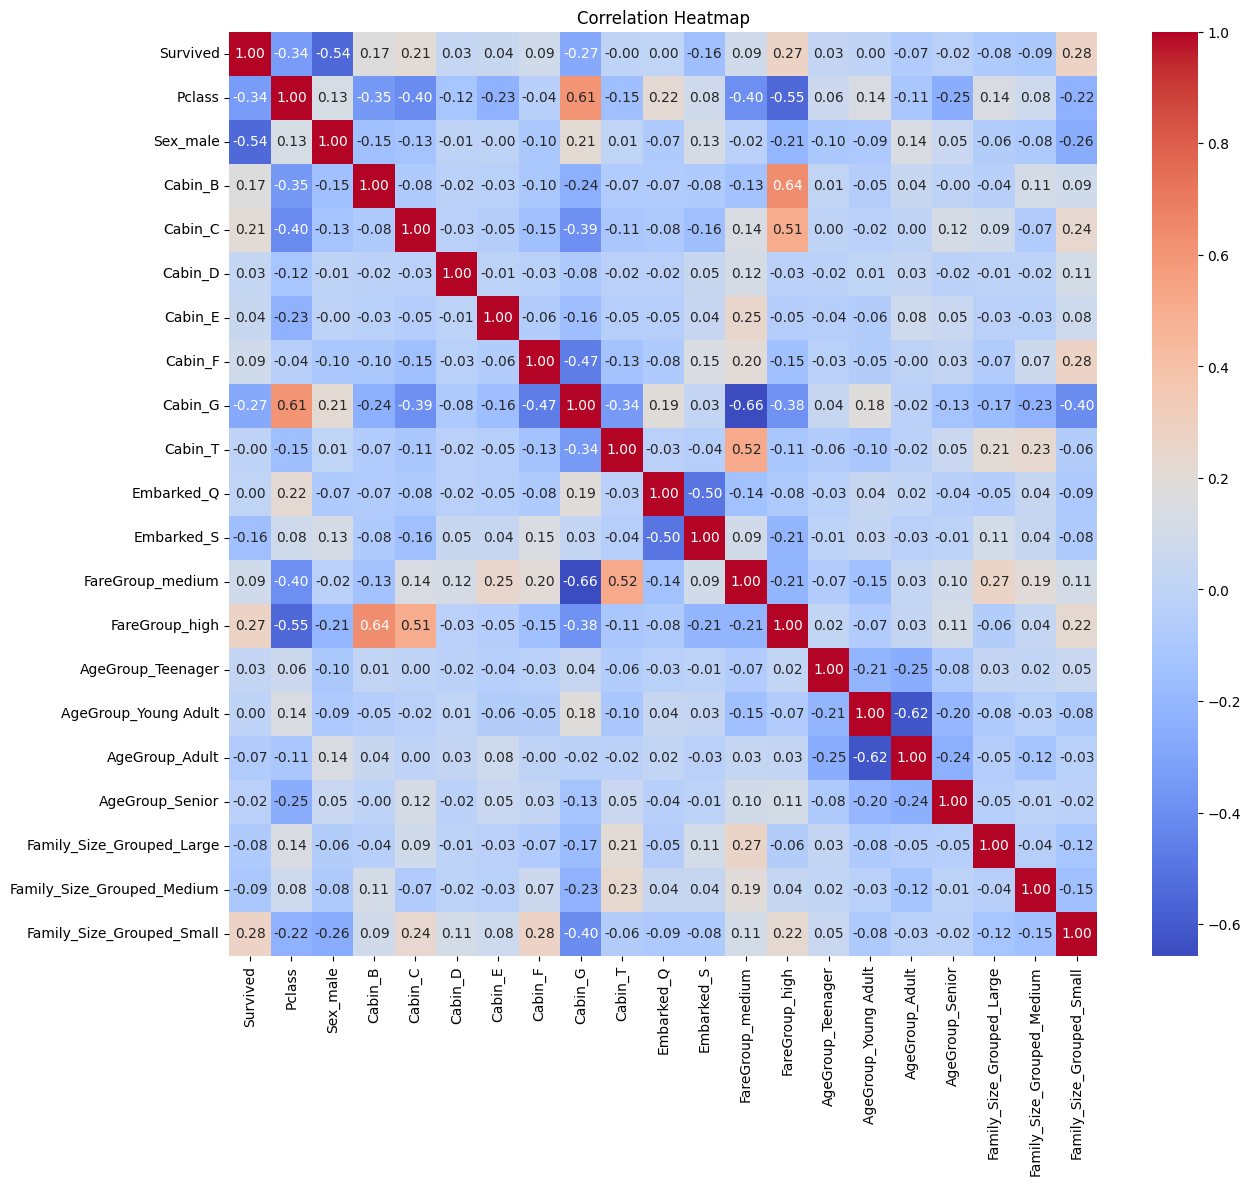

In [41]:
plt.figure(figsize=(14, 12))
sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

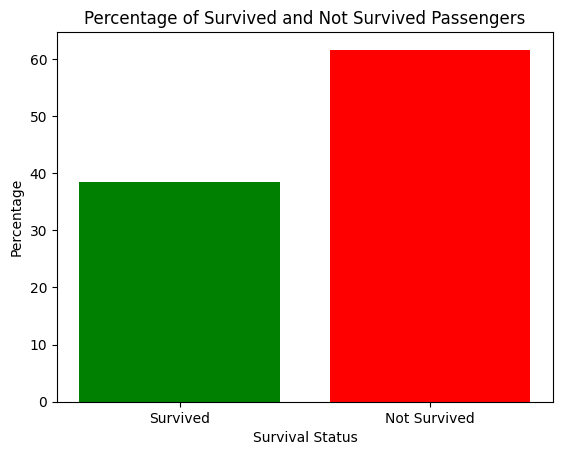

In [42]:
# Calculate the percentage of survived and not survived passengers
survived_percentage = df_train['Survived'].mean() * 100
not_survived_percentage = 100 - survived_percentage

# Create a bar plot
plt.bar(['Survived', 'Not Survived'], [survived_percentage, not_survived_percentage], color=['green', 'red'])
plt.title('Percentage of Survived and Not Survived Passengers')
plt.xlabel('Survival Status')
plt.ylabel('Percentage')
plt.show()

# Class Imbalance and Its Impact on Model Performance

## Introduction

Class imbalance occurs when the distribution of classes in a dataset is not uniform, meaning one class significantly outnumbers the others. In the context of binary classification, it often refers to a situation where one class is the majority (negative class), and the other is the minority (positive class). This imbalance can have a profound impact on machine learning models, leading to biased predictions and decreased performance.

## Effects of Class Imbalance

### 1. **Model Bias:**
   - Imbalanced datasets can lead to biased models that favor the majority class, as the model tends to learn more from the prevalent class.

### 2. **Poor Generalization:**
   - Models trained on imbalanced data may struggle to generalize well to new, unseen data, especially for the minority class.

### 3. **Misleading Evaluation Metrics:**
   - Traditional accuracy may not be an informative metric, as a model predicting only the majority class could achieve high accuracy. Therefore, alternative metrics like precision, recall, and F1 score become crucial.

### 4. **Ineffective Learning:**
   - The minority class may not receive sufficient attention during model training, leading to poor performance in predicting instances of that class.

## Approach with 4 Models

In our analysis, we will explore the impact of class imbalance on four different machine learning models:

1. **Decision Trees:**
   - Decision trees are prone to favor the majority class in imbalanced datasets. We will evaluate their performance and discuss potential tuning strategies.

2. **Random Forest:**
   - Random forests, being an ensemble of decision trees, also face challenges with class imbalance. We will explore hyperparameter tuning to mitigate these issues.

3. **XGBoost:**
   - XGBoost is known for its robustness, but it's essential to assess its performance in the presence of class imbalance. We will fine-tune its parameters to achieve better results.

4. **Support Vector Machines (SVM):**
   - SVMs may be affected by imbalanced datasets, particularly if not configured correctly. We will optimize SVM hyperparameters to enhance its performance.

By systematically addressing class imbalance and optimizing model parameters, we aim to improve the overall predictive capabilities of these models on imbalanced datasets.

In [43]:
df_train['Survived'] = df_train['Survived'].astype('int64')

X = df_train.drop('Survived', axis=1)
y = df_train['Survived']

SEED = 0

# Instantiate the oversampler
ros = RandomOverSampler(random_state=42)

# Apply oversampling to the training set only
X_train_resampled, y_train_resampled = ros.fit_resample(X, y)

# Split the resampled training data into training and testing sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.25, random_state=42, stratify=y_train_resampled)

# Display the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (823, 20) (823,)
Testing set shape: (275, 20) (275,)


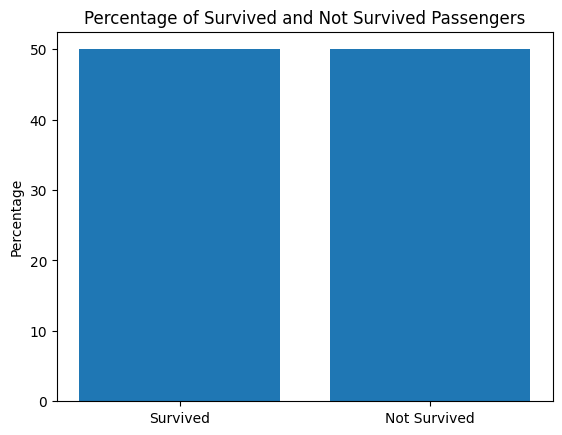

In [44]:
# check balanced dataset
# Calculate the percentage of survived and not survived passengers
survived_percentage = y_train_resampled.mean() * 100
not_survived_percentage = 100 - survived_percentage

# Create a bar plot
import matplotlib.pyplot as plt

plt.bar(['Survived', 'Not Survived'], [survived_percentage, not_survived_percentage])
plt.ylabel('Percentage')
plt.title('Percentage of Survived and Not Survived Passengers')
plt.show()

### Support functions to evaluate models and save score

In [45]:
# creating a confusion matrix display function
def display_confusion_matrix_and_metrics(y_true, y_pred):
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Set a custom color palette
    cmap = 'summer' #sns.diverging_palette(220, 20, as_cmap=True)

    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap, cbar=True, annot_kws={"size": 16})
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# calculate metrics for model
def calculate_metrics(y_true, y_pred):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Create a dictionary with metric names and values
    metrics_dict = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    # Display evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    return metrics_dict

# Create an empty DataFrame for storing model results
model_results = pd.DataFrame(columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])

# Define the add_results function
def add_results(model_name, metrics_dict):
    """
    Add model results to the model_results DataFrame.

    Parameters:
    - model_name: Name of the model.
    - metrics_dict: Dictionary containing model evaluation metrics.
    """

    global model_results  # Declare model_results as a global variable

    # Create a new row with model results
    new_row = pd.DataFrame({'Model': [model_name],
                            'Accuracy': [metrics_dict['accuracy']],
                            'F1 Score': [metrics_dict['f1']],
                            'Precision': [metrics_dict['precision']],
                            'Recall': [metrics_dict['recall']]})

    # Append the new row to the model_results DataFrame
    model_results = pd.concat([model_results, new_row], ignore_index=True)

## **Decision Trees**

In [46]:
# Build and Train
decision_tree = DecisionTreeClassifier(random_state=SEED)

# Fit the model on the training data
decision_tree.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = decision_tree.predict(X_test)

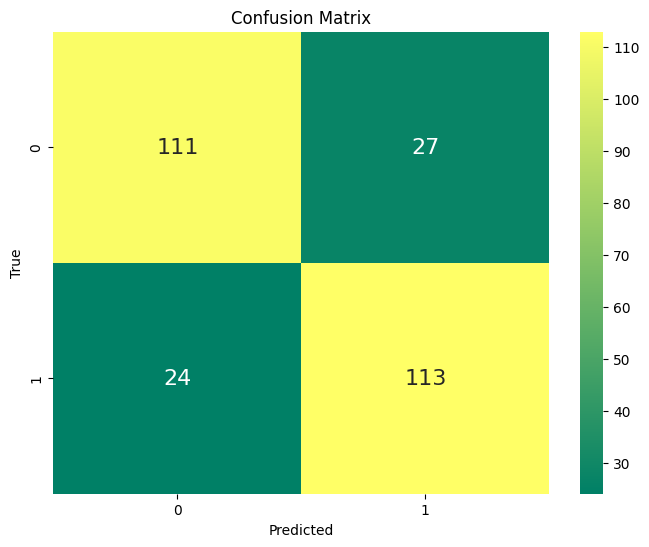

Accuracy: 0.8145454545454546
Precision: 0.8071428571428572
Recall: 0.8248175182481752
F1 Score: 0.8158844765342961


,Model,Accuracy,F1 Score,Precision,Recall
0,decision_trees,0.814545,0.815884,0.807143,0.824818


In [47]:
# Evaluate the model
display_confusion_matrix_and_metrics(y_test,y_pred)

# Calculate metrics
metrics = calculate_metrics(y_test, y_pred)


add_results("decision_trees", metrics)

model_results.head()

## **Random Forest**

In [48]:
# Build and Train
rf = RandomForestClassifier(random_state=SEED)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf.predict(X_test)

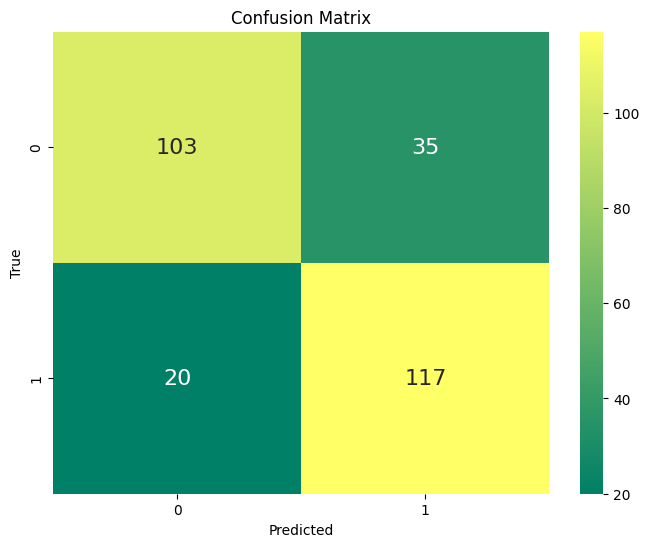

Accuracy: 0.8
Precision: 0.7697368421052632
Recall: 0.8540145985401459
F1 Score: 0.8096885813148789


,Model,Accuracy,F1 Score,Precision,Recall
0,decision_trees,0.814545,0.815884,0.807143,0.824818
1,random_forest,0.800000,0.809689,0.769737,0.854015


In [49]:
# Evaluate the model
display_confusion_matrix_and_metrics(y_test,y_pred)

# Calculate metrics
metrics = calculate_metrics(y_test, y_pred)


add_results("random_forest", metrics)

model_results.head()

## **XGBoost**

In [50]:
# Build and Train
xgb = XGBClassifier(objective='binary:logistic', random_state=SEED)

# Fit the model on the training data
xgb.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = xgb.predict(X_test)

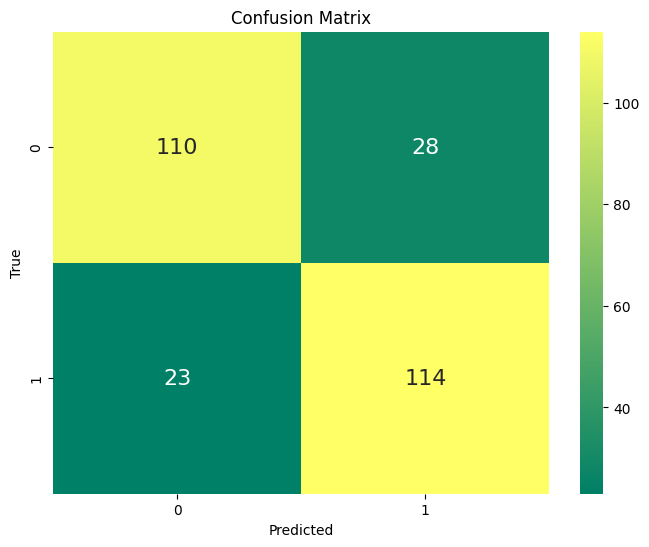

Accuracy: 0.8145454545454546
Precision: 0.8028169014084507
Recall: 0.8321167883211679
F1 Score: 0.8172043010752689


,Model,Accuracy,F1 Score,Precision,Recall
0,decision_trees,0.814545,0.815884,0.807143,0.824818
1,random_forest,0.800000,0.809689,0.769737,0.854015
2,xgboost,0.814545,0.817204,0.802817,0.832117


In [51]:
# Evaluate the model
display_confusion_matrix_and_metrics(y_test,y_pred)

# Calculate metrics
metrics = calculate_metrics(y_test, y_pred)


add_results("xgboost", metrics)

model_results.head()

## **SVM**

In [52]:
# Build and Train
svm = SVC(random_state=SEED)

# Fit the model on the training data
svm.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = svm.predict(X_test)

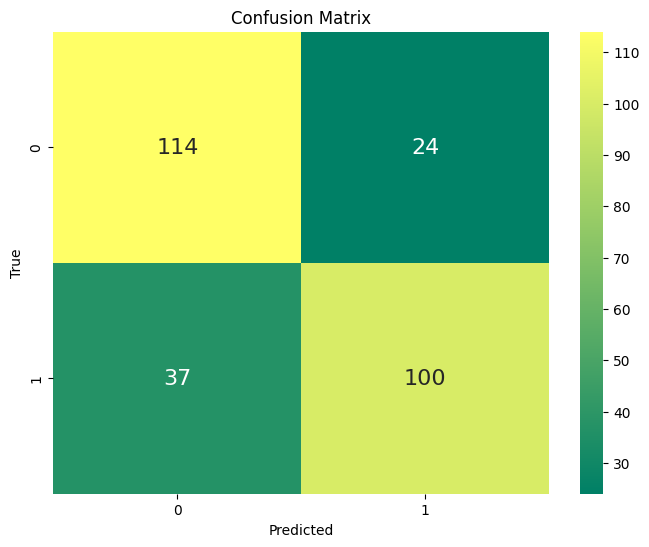

Accuracy: 0.7781818181818182
Precision: 0.8064516129032258
Recall: 0.7299270072992701
F1 Score: 0.7662835249042146


,Model,Accuracy,F1 Score,Precision,Recall
0,decision_trees,0.814545,0.815884,0.807143,0.824818
1,random_forest,0.800000,0.809689,0.769737,0.854015
2,xgboost,0.814545,0.817204,0.802817,0.832117
3,svm,0.778182,0.766284,0.806452,0.729927


In [53]:
# Evaluate the model
display_confusion_matrix_and_metrics(y_test,y_pred)

# Calculate metrics
metrics = calculate_metrics(y_test, y_pred)


add_results("svm", metrics)

model_results.head()

# Hyperparameters Tuning

## Scoring in Cross-Validation

When performing cross-validation to tune hyperparameters, you need to choose a scoring metric to evaluate the performance of different parameter combinations. The choice of scoring metric depends on the nature of your problem:

- For classification problems, common scoring metrics include:
  - 'accuracy': Percentage of correct predictions.
  - 'precision': Proportion of true positive predictions among all positive predictions.
  - 'recall': Proportion of true positive predictions among all actual positive instances.
  - 'f1': Harmonic mean of precision and recall.
  
**We are going to use accuracy for our models**

# Decision Tree Tuning
## Decision Tree Hyperparameters

The following hyperparameters are considered for tuning the Decision Tree model:

### `max_depth`
- **Description**: Maximum depth of the tree.
- **Impact**: Controls the depth of the tree. Deeper trees can capture more complex patterns but may lead to overfitting. `None` allows the tree to expand until all leaves are pure or contain less than `min_samples_split` samples.

### `min_samples_split`
- **Description**: Minimum number of samples required to split an internal node.
- **Impact**: Determines how many samples are needed to make a new split. Higher values prevent creating nodes that are too specific, reducing the risk of overfitting.

### `min_samples_leaf`
- **Description**: Minimum number of samples required to be at a leaf node.
- **Impact**: Similar to `min_samples_split`, it controls the size of the leaf. Larger leaf sizes smooth the model and can improve generalization by preventing overfitting.

### `max_features`
- **Description**: Number of features to consider when looking for the best split.
- **Impact**: Defines how many features are considered for each split. `None` uses all features, while `'sqrt'` and `'log2'` use a subset, adding randomness and potentially improving generalization.

### `criterion`
- **Description**: The function used to measure the quality of a split.
- **Impact**: 'gini' uses Gini impurity as the criterion, while 'entropy' uses information gain. Different criteria can lead to different performance and tree structures.


In [54]:
# Define the model
dt = DecisionTreeClassifier(random_state = SEED)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Set up the grid search with 'accuracy' as the scoring metric
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring=scoring,refit='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Getting the best parameters and the corresponding best accuracy
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_parameters)
print("Best Accuracy:", best_accuracy)

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 15}
Best Accuracy: 0.8188987435328897


In [55]:
# Optimal parameters for DecisionTreeClassifier
dt_opt = DecisionTreeClassifier(criterion='entropy', 
                                max_depth=10, 
                                max_features=None, 
                                min_samples_leaf=1, 
                                min_samples_split=15,
                                random_state=SEED)

# Fit the optimal model
dt_opt.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_opt.predict(X_test)

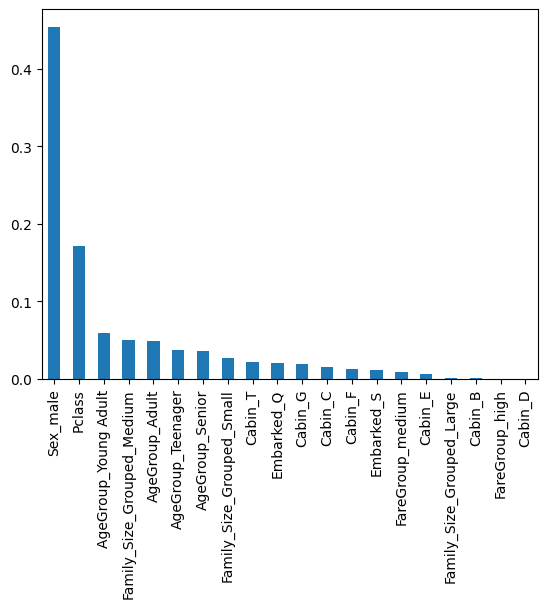

In [56]:
# Feature importance
importances = dt_opt.feature_importances_

forest_importances = pd.Series(importances, index=X_test.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax);

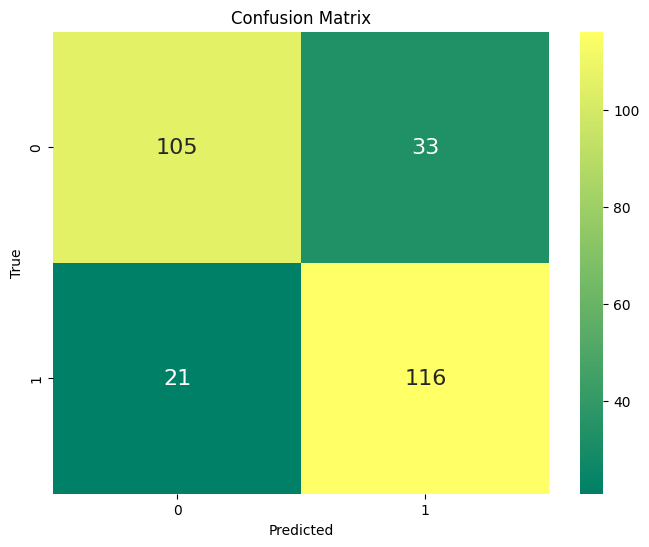

Accuracy: 0.8036363636363636
Precision: 0.7785234899328859
Recall: 0.8467153284671532
F1 Score: 0.811188811188811


In [57]:
# Evaluate the model
display_confusion_matrix_and_metrics(y_test,y_pred)

# Calculate metrics
metrics = calculate_metrics(y_test, y_pred)


add_results("decision_trees_tuned", metrics)

In [58]:
model_results.head(10)

,Model,Accuracy,F1 Score,Precision,Recall
0,decision_trees,0.814545,0.815884,0.807143,0.824818
1,random_forest,0.800000,0.809689,0.769737,0.854015
2,xgboost,0.814545,0.817204,0.802817,0.832117
3,svm,0.778182,0.766284,0.806452,0.729927
4,decision_trees_tuned,0.803636,0.811189,0.778523,0.846715


# Tuning Random Forest

## Random Forest Hyperparameters

The following hyperparameters are considered for tuning the Random Forest model:

### `n_estimators`
- **Description**: Number of trees in the forest.
- **Impact**: More trees can lead to better performance but increase computational cost. Fewer trees are faster but may not capture all the patterns in the data.

### `max_depth`
- **Description**: Maximum depth of each tree.
- **Impact**: Controls the depth of each tree. Deeper trees can capture more complex patterns but may lead to overfitting. `None` allows trees to grow until all leaves are pure or contain less than `min_samples_split` samples.

### `min_samples_split`
- **Description**: Minimum number of samples required to split an internal node.
- **Impact**: Determines the minimum number of samples needed to split a node. Higher values prevent the creation of nodes that are too specific, which can reduce overfitting.

### `min_samples_leaf`
- **Description**: Minimum number of samples required to be at a leaf node.
- **Impact**: Similar to `min_samples_split`, it controls the size of the leaf nodes. Larger values can help improve model generalization and prevent overfitting.

### `max_features`
- **Description**: Number of features to consider when looking for the best split.
- **Impact**: Determines how many features are considered for finding the best split at each node. `None` uses all features; `'sqrt'` and `'log2'` reduce the number of features, adding randomness and potentially improving model performance.

### `bootstrap`
- **Description**: Method for sampling data points (with or without replacement).
- **Impact**: `True` indicates bootstrapping samples (with replacement) for building trees, which is typical in Random Forest. `False` uses the whole dataset to build each tree, which can reduce randomness but increase variance.


In [59]:
# Define the model
rf = RandomForestClassifier(random_state = SEED)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 300, 500 , 1000],
    'max_depth': [3, 10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 5],
    'max_features': [ None, 'sqrt', 'log2']
}

scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Set up the grid search with 'accuracy' as the scoring metric
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=scoring , refit='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Getting the best parameters and the corresponding best accuracy
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_parameters)
print("Best Accuracy:", best_accuracy)

Best Parameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best Accuracy: 0.8164375461936437


In [60]:
# Optimal parameters on GridSearchCV.
rf_opt = RandomForestClassifier(n_estimators = 300, max_depth = 20, 
                                min_samples_leaf = 1, min_samples_split = 10,
                                max_features=None,random_state = SEED)

# Fit the optimal model.
rf_opt.fit(X_train, y_train)

# Predict on test set.
y_pred = rf_opt.predict(X_test)

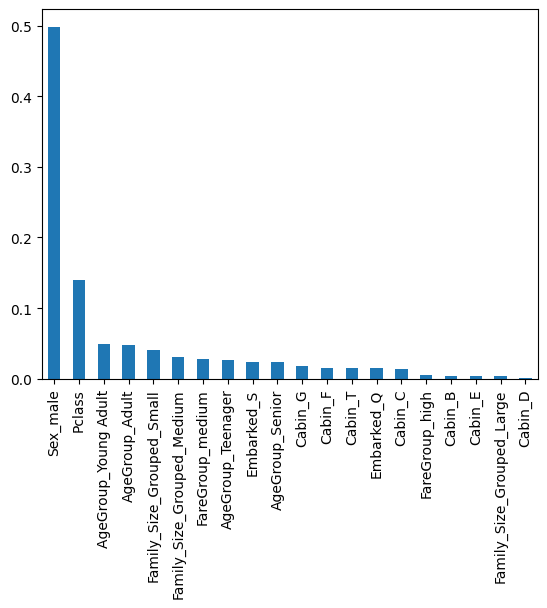

In [61]:
# Feature importance
importances = rf_opt.feature_importances_

forest_importances = pd.Series(importances, index=X_test.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax);

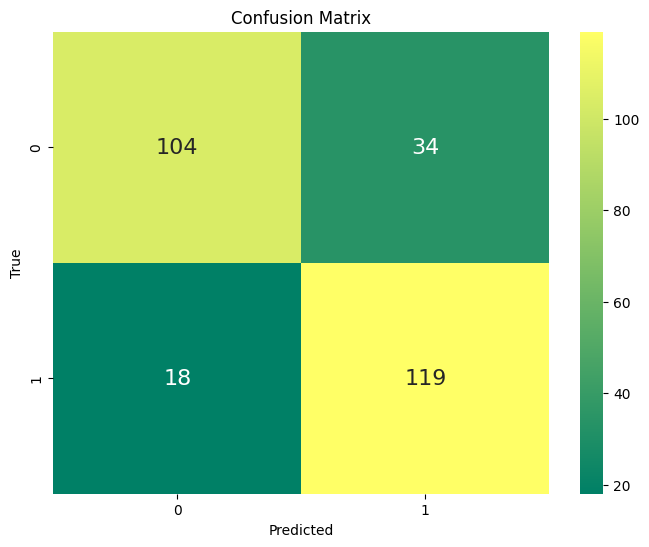

Accuracy: 0.8109090909090909
Precision: 0.7777777777777778
Recall: 0.8686131386861314
F1 Score: 0.8206896551724138


In [62]:
# Compute confusion matrix
display_confusion_matrix_and_metrics(y_test, y_pred)
# Compute metrics
metrics = calculate_metrics(y_test, y_pred)
# Add model results to the data frames 
add_results('random_forest_tuned', metrics)

In [63]:
model_results.head(10)

,Model,Accuracy,F1 Score,Precision,Recall
0,decision_trees,0.814545,0.815884,0.807143,0.824818
1,random_forest,0.800000,0.809689,0.769737,0.854015
2,xgboost,0.814545,0.817204,0.802817,0.832117
3,svm,0.778182,0.766284,0.806452,0.729927
4,decision_trees_tuned,0.803636,0.811189,0.778523,0.846715
5,random_forest_tuned,0.810909,0.820690,0.777778,0.868613


# Tuning XGBoost
## XGBoost Hyperparameters

XGBoost is a powerful machine learning algorithm especially for structured data. Below are key hyperparameters that are commonly tuned:

### `n_estimators`
- **Description**: Number of gradient boosted trees.
- **Impact**: More trees can improve performance but may lead to overfitting. It's essential to balance this with the learning rate.

### `learning_rate`
- **Description**: Step size shrinkage used to prevent overfitting.
- **Impact**: Controls the rate of learning. Smaller values make the process more conservative, requiring more trees but can lead to better final models.

### `max_depth`
- **Description**: Maximum depth of a tree.
- **Impact**: Controls the depth of each tree. Deeper trees can model more complex patterns but can also lead to overfitting.

### `subsample`
- **Description**: Subsample ratio of the training instances.
- **Impact**: Fraction of the training data to be used for training each tree. Lower values can help prevent overfitting.

### `colsample_bytree`
- **Description**: Subsample ratio of columns when constructing each tree.
- **Impact**: Fraction of features to be used for each tree. Similar to `max_features` in Random Forests, it adds randomness to the model.

### `gamma`
- **Description**: Minimum loss reduction required to make a further partition on a leaf node of the tree.
- **Impact**: A higher value leads to more conservative models, acting as a regularization parameter.

### `reg_alpha` (L1 regularization term)
- **Description**: L1 regularization term on weights.
- **Impact**: Can be used for feature selection, leading to sparser trees.

### `reg_lambda` (L2 regularization term)
- **Description**: L2 regularization term on weights.
- **Impact**: Adds regularization to the model. Helps in preventing overfitting.

In [64]:
# Initialize XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=SEED, use_label_encoder=False)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2]
}


# Define multiple scoring metrics
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Set up GridSearchCV with multiple scoring and refit for accuracy
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1)

# Fit grid search to the data
grid_search.fit(X_train, y_train)

# Getting the best parameters and corresponding best accuracy
best_parameters = grid_search.best_params_
best_scores = grid_search.cv_results_

print("Best Parameters:", best_parameters)
print("Best Accuracy:", best_scores['mean_test_accuracy'][grid_search.best_index_])

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 1}
Best Accuracy: 0.811611234294161


In [65]:
# Optimal Hyperparameters for XGBoost
best_params = {'colsample_bytree': 0.8, 'gamma': 0.1,
               'learning_rate': 0.1,
               'max_depth': 5, 'n_estimators': 100,
               'reg_alpha': 0.1,
               'reg_lambda': 1, 'subsample': 1}

# Construct the XGBoost model with the Optimal hyperparameters
xgb_opt = XGBClassifier(**best_params, random_state=SEED)

# Fit the model on the training data
xgb_opt.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_opt.predict(X_test)

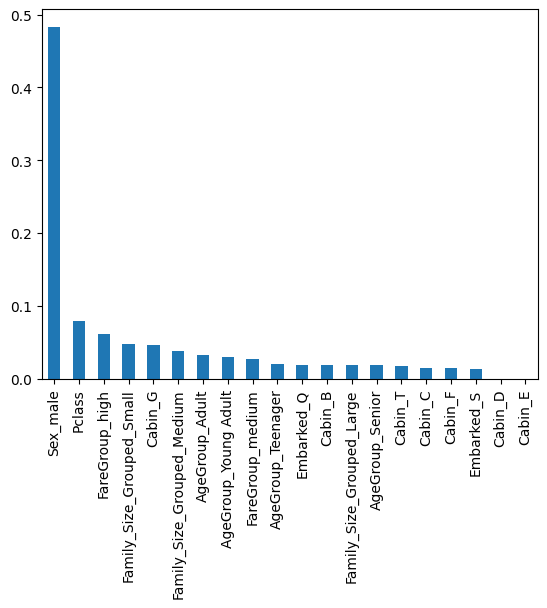

In [66]:
# Feature importance
importances = xgb_opt.feature_importances_

forest_importances = pd.Series(importances, index=X_test.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax);

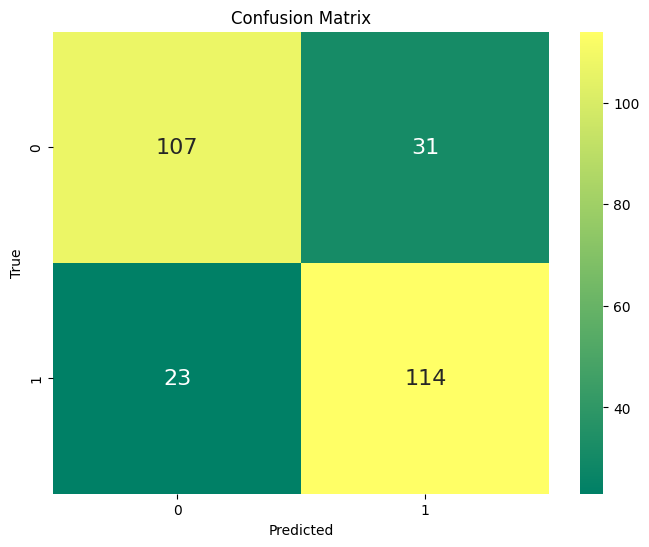

Accuracy: 0.8036363636363636
Precision: 0.7862068965517242
Recall: 0.8321167883211679
F1 Score: 0.8085106382978724


In [67]:
# Compute confusion matrix
display_confusion_matrix_and_metrics(y_test, y_pred)
# Compute metrics
metrics = calculate_metrics(y_test, y_pred)
# Add model results to the data frames 
add_results('XGBoost_tuned', metrics)

In [68]:
model_results.head(10)

,Model,Accuracy,F1 Score,Precision,Recall
0,decision_trees,0.814545,0.815884,0.807143,0.824818
1,random_forest,0.800000,0.809689,0.769737,0.854015
2,xgboost,0.814545,0.817204,0.802817,0.832117
3,svm,0.778182,0.766284,0.806452,0.729927
4,decision_trees_tuned,0.803636,0.811189,0.778523,0.846715
5,random_forest_tuned,0.810909,0.820690,0.777778,0.868613
6,XGBoost_tuned,0.803636,0.808511,0.786207,0.832117


# SVM TUNING
## SVM Hyperparameters

When tuning a Support Vector Machine (SVM), several key hyperparameters significantly influence the model's performance:

### `C` (Regularization parameter)
- **Description**: Controls the trade-off between creating a smooth decision boundary and classifying training points correctly. A smaller value of `C` creates a smoother decision boundary at the cost of training accuracy, whereas a larger `C` aims to classify all training examples correctly by giving the model freedom to select more samples as support vectors.
- **Suggested Values**: `[0.01, 0.1, 1, 10, 100]`

### `kernel`
- **Description**: The type of kernel used in SVM. It defines the decision boundary between the classes. Different kernels are suitable for different types of data.
- **Suggested Values**: `['linear', 'rbf', 'poly']`
  - `'linear'`: Used for linearly separable data.
  - `'rbf'` (Radial Basis Function): Useful for non-linear hyperplane.
  - `'poly'` (Polynomial): Good for data where the relationship between features is not linear.

### `gamma` (Kernel coefficient)
- **Description**: For non-linear kernels, it defines how far the influence of a single training example reaches. High values lead to more complex models.
- **Suggested Values**: `['scale', 'auto', 0.01, 0.1, 1]`
  - `'scale'`: Automatically adjusts gamma based on the number of features.
  - `'auto'`: Uses `1/n_features`.

### `degree`
- **Description**: Degree of the polynomial kernel function (`'poly'`). Ignored by all other kernels.
- **Suggested Values**: `[2, 3, 4]`
- **Impact**: Higher degrees mean considering more complex models (higher-order polynomials), which can lead to overfitting for some datasets.

### `shrinking`
- **Description**: A heuristic approach to simplify the calculations. True by default. When set to False, it forces the model to use the full optimization problem.
- **Suggested Values**: `[True, False]`

### `class_weight`
- **Description**: Adjusts weights inversely proportional to class frequencies in the input data. Useful for unbalanced classes.
- **Suggested Values**: `[None, 'balanced']`
  - `None`: No weights are applied.
  - `'balanced'`: Automatically adjust weights inversely proportional to class frequencies.

In [69]:
# Declare the SVM model
svm_model = SVC(random_state=SEED)

# Define the hyperparameter grid
cv_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
    'degree': [2, 4],  # Only relevant for 'poly' kernel
    'shrinking': [True, False],
    'class_weight': [None, 'balanced']
}

# Define custom scorers with zero_division parameter set to 0
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

# Construct the GridSearch with multiple scoring metrics
svm_grid_search = GridSearchCV(svm_model,
                               cv_params,
                               scoring=scoring_metrics,
                               cv=5,
                               refit='accuracy',
                               n_jobs=-1  # Use parallel processing
                              )

# Fit the grid search to your data
svm_grid_search.fit(X_train, y_train)

# Getting the best parameters and corresponding best scores
best_parameters = svm_grid_search.best_params_
best_index = svm_grid_search.best_index_

# Display the best hyperparameters
print("Best Hyperparameters:", best_parameters)
print("Best Accuracy:", svm_grid_search.cv_results_['mean_test_accuracy'][best_index])

Best Hyperparameters: {'C': 1, 'class_weight': None, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly', 'shrinking': True}
Best Accuracy: 0.8079822616407982


In [70]:
# Optimal Hyperparameters for SVM
best_params = {'C': 1, 'class_weight': None,
               'degree': 4,
               'gamma': 'scale',
               'kernel': 'poly',
               'shrinking': True}

# Construct the model with the Optimal hyperparameters
svm_opt = SVC(**best_params, random_state=SEED)

# Fit the model on the training data
svm_opt.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_opt.predict(X_test)

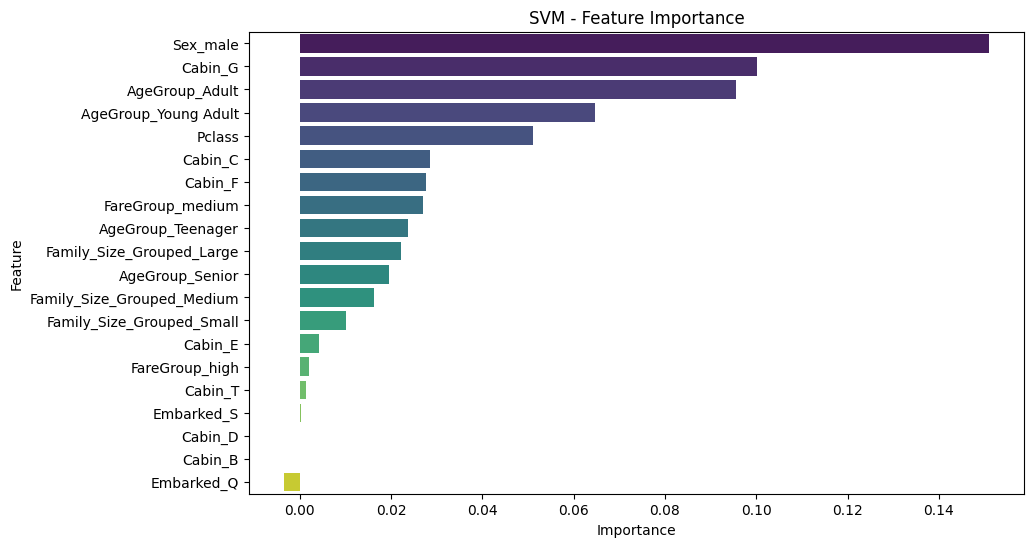

In [71]:
from sklearn.inspection import permutation_importance

# Feature importance using permutation importance
importance = permutation_importance(svm_opt, X_test, y_test, n_repeats=30, random_state=SEED)

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance.importances_mean})

# Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('SVM - Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

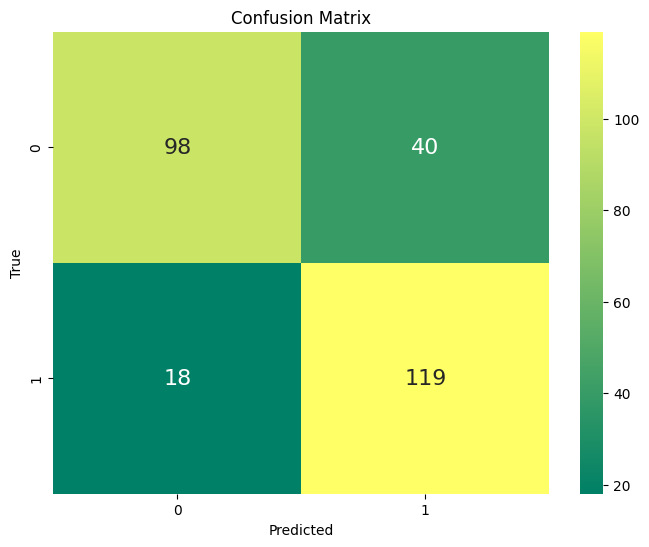

Accuracy: 0.7890909090909091
Precision: 0.7484276729559748
Recall: 0.8686131386861314
F1 Score: 0.8040540540540541


In [72]:
# Compute confusion matrix
display_confusion_matrix_and_metrics(y_test, y_pred)
# Compute metrics
metrics = calculate_metrics(y_test, y_pred)
# Add model results to the data frames 
add_results('svm_tuned', metrics)

In [73]:
model_results.sort_values(by='Accuracy', ascending=False).head(20)

,Model,Accuracy,F1 Score,Precision,Recall
0,decision_trees,0.814545,0.815884,0.807143,0.824818
2,xgboost,0.814545,0.817204,0.802817,0.832117
5,random_forest_tuned,0.810909,0.820690,0.777778,0.868613
4,decision_trees_tuned,0.803636,0.811189,0.778523,0.846715
6,XGBoost_tuned,0.803636,0.808511,0.786207,0.832117
1,random_forest,0.800000,0.809689,0.769737,0.854015
7,svm_tuned,0.789091,0.804054,0.748428,0.868613
3,svm,0.778182,0.766284,0.806452,0.729927


## Model Performance Analysis

The performance of various machine learning models has been evaluated based on four key metrics: Accuracy, F1 Score, Precision, and Recall. Here's a summary of their performances:

| Model               | Accuracy | F1 Score | Precision | Recall  |
|---------------------|----------|----------|-----------|---------|
| Decision Trees      | 0.8145   | 0.8159   | 0.8071    | 0.8248  |
| XGBoost             | 0.8145   | 0.8172   | 0.8028    | 0.8321  |
| Random Forest (Tuned)| 0.8109   | 0.8207   | 0.7778    | 0.8686  |
| Decision Trees (Tuned)| 0.8036   | 0.8112   | 0.7785    | 0.8467  |
| XGBoost (Tuned)     | 0.8036   | 0.8085   | 0.7862    | 0.8321  |
| Random Forest       | 0.8000   | 0.8097   | 0.7697    | 0.8540  |
| SVM (Tuned)         | 0.7891   | 0.8041   | 0.7484    | 0.8686  |
| SVM                 | 0.7782   | 0.7663   | 0.8065    | 0.7299  |

### Observations and Conclusions:

1. **Top Performers**: Decision Trees and XGBoost (untuned versions) share the highest accuracy and F1 scores, suggesting robust performance across both precision and recall.

2. **Effect of Tuning**: Tuning the Random Forest model slightly improves its recall, making it the best model for minimizing false negatives. However, tuning Decision Trees and XGBoost results in a slight decrease in performance, indicating that the default parameters were already quite effective for this dataset.

3. **Precision vs. Recall**: There is an evident trade-off between precision and recall among the models. SVM (Tuned) and Random Forest (Tuned) show higher recall but at the cost of lower precision, which might be preferable in scenarios where missing a positive instance (false negative) is more critical.

4. **SVM Performance**: SVM models, both tuned and untuned, lag behind tree-based models in terms of overall accuracy and F1 score. However, the tuned SVM shows a significant improvement in recall, making it a potential choice for applications where recall is more important.

### Recommendations:

- For applications requiring a balance between precision and recall, **Decision Trees** and **XGBoost** are recommended.
- In cases where high recall is more critical, consider using **Random Forest (Tuned)** or **SVM (Tuned)**.
- Further model-specific tuning and feature engineering might yield improvements, especially for the models that didn't perform as well in their untuned state.

### Practical Considerations

- **Model Complexity and Training Time**: While not directly measured here, these factors are crucial in a real-world setting. Decision Trees are typically faster and simpler compared to models like XGBoost.

- **Application Scenarios**: For instance, in a spam detection system, precision might be more critical to minimize legitimate emails being classified as spam. In contrast, in medical diagnosis, a high recall is usually more important.

## Decision Tree vs. XGBoost: Pros, Cons, and Recommendation

### Decision Tree
**Pros:**
- **Simplicity and Speed**: Decision Trees are relatively simple to understand and quick to train.
- **Interpretability**: They offer high interpretability as the decision process can be easily visualized.
- **Less Prone to Overfitting**: If not very deep, they are less likely to overfit compared to more complex models.

**Cons:**
- **Handling Complex Patterns**: May not capture complex patterns as effectively as ensemble methods like XGBoost.
- **Variance**: A small change in the data can lead to a significantly different tree.
- **Performance Ceiling**: Often have a lower performance ceiling in terms of accuracy, especially on complex datasets.

### XGBoost
**Pros:**
- **Handling Complexity**: Excellent at handling a variety of data types, relationships, and distributions.
- **Higher Performance**: Generally delivers higher accuracy, especially on larger and more complex datasets.
- **Feature Importance**: Provides insights into the significance of different features for predictions.

**Cons:**
- **Interpretability**: More complex and less interpretable compared to a single Decision Tree.
- **Training Time**: Requires more computational resources and time to train.
- **Risk of Overfitting**: If not tuned properly, can overfit the training data.

#### Considerations for Final Decision:
- **Dataset Complexity and Size**: Opt for XGBoost for complex, large datasets; consider Decision Trees for simpler, smaller datasets.
- **Interpretability Needs**: If you need to easily explain the model's decisions, Decision Trees are preferable.
- **Computational Resources and Training Time**: If limited, a Decision Tree might be more practical.

# Conclusion and Decision

After evaluating the available options, we have decided to move forward with **XGBoost** for our analysis. Despite our dataset being relatively small, XGBoost's superior capability in managing categorical variables and unraveling complex relationships between diverse features makes it a more suitable choice over Decision Trees. We anticipate that this approach will yield more accurate and insightful predictions, essential for the objectives of our project.

We are therefore proceeding with the implementation of the XGBoost model in our analysis.

In [74]:
# Build and Train
xgb = XGBClassifier(objective='binary:logistic', random_state=SEED, use_label_encoder=False)

# Fit the model on the training data
xgb.fit(X, y)


df_test = df_test.drop('Survived', axis=1)
# Make predictions on the Test data
y_pred = xgb.predict(df_test)

In [75]:
test = pd.read_csv('/kaggle/input/titanic/test.csv')
# Submit the results
submission = pd.DataFrame({
        "PassengerId":test["PassengerId"],
        "Survived": y_pred})

submission['Survived'] = submission['Survived'].astype('Int64')

submission.to_csv('submission.csv', index=False)

## Acknowledgments

I would like to express my gratitude to the following notebooks, which were instrumental in guiding and enhancing my analysis:

1. [Titanic EDA: A comprehensive exploration of the dataset](https://www.kaggle.com/code/computervisi/titanic-eda#Sinking) by MLCV
   - This notebook provided valuable insights into exploratory data analysis (EDA) for the Titanic dataset. It greatly influenced the way I approached feature analysis and visualization.

2. [Titanic Model with 90% Accuracy](https://www.kaggle.com/code/vinothan/titanic-model-with-90-accuracy/notebook#Random-Forest-Classifier) by VK_DS
   - This notebook presented an in-depth exploration of various machine learning models on the Titanic dataset, with a specific focus on the Random Forest Classifier. It was particularly helpful in understanding model selection and hyperparameter tuning.

I appreciate the authors for their contributions to the Kaggle community, as their work significantly contributed to the success of this project.


## Seeking Feedback

🙏 **Feedback Requested!** 🙏

I welcome and appreciate feedback from the Kaggle community. If you have any suggestions, improvements, or insights regarding my analysis, please feel free to share them in the comments section.

- Is there anything I might have missed in my analysis?
- Do you have ideas for additional features or techniques that could enhance the model?
- Any constructive criticism or tips for improvement are highly valued.

Your input is crucial in the collaborative spirit of learning and growing together. Let's make this analysis better with your valuable comments! Thank you for your time and insights. 🚀
